In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import round
from pyspark.sql import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import log
from pyspark.sql.functions import regexp_replace
import matplotlib.pyplot as plt  
import scipy.stats as st
import seaborn as sns
import pandas as pd
from operator import add
from functools import reduce

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/18 15:30:07 WARN Utils: Your hostname, hexiangyideMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.177.117 instead (on interface en0)
22/10/18 15:30:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/18 15:30:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/18 15:30:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/18 15:30:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/18 15:30:09 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/18 15:30:09 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
# Read processed Dataframe for ranking
final = spark.read.parquet('../data/curated/merchant_info.parquet')
final_pd = final.toPandas()

In [3]:
# Select all the numeric features
col_list_1 = final.columns

del_col_list = ['Store_type', 'Revenue_levels', 'merchant_abn','postcode']

for i in del_col_list:
    col_list_1.remove(i)

In [4]:
final.limit(3)

Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,postcode,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,merchant_abn,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value
"furniture, home f...",e,3795.4763999999996,0,21085.98,117.83,178.95,2388,15.755309718035436,0.00399800099950025,111.17,10023283211,0,0.2217391304347826,0.5576256499133448,142.6988983154297
"cable, satellite,...",b,11460.253999999999,0,2715.7,104.17,26.07,6438,15.956177986359188,0.005056179775280...,98.89,10142254217,0,0.30401763841254287,0.7375104079933389,36.930999755859375
"jewelry, watch, c...",b,8707.996000000001,2,1979.09,0.17,11874.56,6421,23.896671077076075,0.0,0.17,10165489824,0,0.27759516139635787,0.5837680097854485,29.307025909423828


In [5]:
# Input origginal dataframe, return new dataframe that mapping numeric and ordinal data to 0-100 
# in order to make all the features in same scale for calculating the score
def get_map_df(unsort_df, col_list_1):
    max_list = []
    min_list = []
    # Calculate max and min value in each numeric features
    for i in col_list_1:
        max_num = float(final.agg({i: "max"}).collect()[0][0])
        min_num = float(final.agg({i: "min"}).collect()[0][0])
        max_list.append(max_num)
        min_list.append(min_num)
    # Map each feature to 0-100
    for i in range(0,12):
        unsort_df = unsort_df.withColumn(col_list_1[i], (col(col_list_1[i]) - min_list[i])*100/(max_list[i]-min_list[i]))
    # Times -1 to fraud features because for fraud less is better
    unsort_df = unsort_df.withColumn('avg_prob_fraud_cus', (unsort_df.avg_prob_fraud_cus *(-1))) \
        .withColumn('prob_of_fraud', (unsort_df.prob_of_fraud*(-1)))
    unsort_df = unsort_df.select('merchant_abn','Store_type', 'Revenue_levels', 'Take_rate', \
        'count_of_bigorder', 'Avg_amount_monthly', 'Avg_count_monthly', 'Order_avg_value',	\
        'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon', 'fix_cus_num', \
        'avg_income_percentage', 'avg_age_percentage','predict_dollar_value')
    # Assign a value to the each revenue level, also in the range 0-100
    reve_list = ['a', 'b', 'c', 'd', 'e']
    reve_num = [0, 25, 50, 75, 100]
    for i in range(len(reve_list)):
        unsort_df = unsort_df.withColumn('Revenue_levels', when(col('Revenue_levels') == reve_list[i], reve_num[i]).otherwise(col('Revenue_levels')))
    return unsort_df

In [6]:
# final_1 is the dataframe after mapping
final_1 = get_map_df(final, col_list_1)

### Baseline Model

In [7]:
# purely add all the scores together without weighting as baseline
pure_add = final_1.withColumn('pure_add_score',reduce(add, [F.col(x) for x in final_1.columns[2:15]]))
pure_add_rank = pure_add.sort(pure_add.pure_add_score.desc())

In [8]:
pure_add_rank

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,pure_add_score
24852446429,florists supplies...,50,31.63246698074998,0.0,64.93905829985881,96.61908031223416,0.036050652902386016,-8.515757029502156,-0.4074534161490683,99.98569077770622,99.14878250103177,52.02931741035037,67.15831110113018,5.704521267340093,558.3300688576527
64203420245,tent and awning s...,50,38.597423859332736,0.0,81.46057277941684,100.0,0.045805535452443404,-8.515942727507571,-0.4073926868044515,100.0,100.0,32.77999166601939,56.78988503398783,5.706711918291284,556.4570553781884
49891706470,tent and awning s...,0,74.08777025492307,0.0,77.10084124650936,94.72489216578857,0.045766978604419466,-8.516445437031965,-0.4074534161490683,99.98569077770622,98.38010730499381,32.77999166601939,56.78988503398783,5.723079183129754,530.6941257584814
86578477987,"watch, clock, and...",0,75.4894451865309,0.0,70.86012404562787,90.94491126998105,0.043395732450947015,-8.514694327549998,-0.4074331710225578,99.99016240967303,97.41023524556336,32.77999166601939,56.78988503398783,5.824660754111644,521.2106838453734
43186523025,florists supplies...,25,53.214050581540704,0.0,71.85393720684161,67.54302174594407,0.06288621912704982,-8.518055429014124,-0.4080007960991143,99.85154181870215,80.42199752373091,36.9926513640861,54.332438369538686,5.81587419744553,486.1623428018436
89726005175,tent and awning s...,0,70.56382161892961,0.0,70.86548168471381,72.61906538708377,0.05685207241130286,-8.513617942528438,-0.4076762454012131,99.93024254131788,85.62216260833678,32.77999166601939,56.78988503398783,5.78488757486859,486.09109599973937
64403598239,music shops - mus...,0,100.0,0.0,95.66210084636779,43.4985112162505,0.14063610316732938,-8.508302420256879,-0.403368123834014,98.5341990412821,42.07078002476269,36.9926513640861,54.332438369538686,5.8530141215530325,468.17266054291736
46804135891,"opticians, optica...",50,21.27721909227452,0.0,43.82131979503459,77.02254443963523,0.02899474971400458,-8.517276461187056,-0.40769651469199025,99.92577090935109,89.23854725546843,32.77999166601939,56.78988503398783,5.728513805708602,467.6878137713146
45629217853,"gift, card, novel...",0,60.55158772943581,0.0,52.35257740389978,74.97966448261967,0.03784354633549933,-8.51413612938101,-0.40759518838850783,99.95081204836518,87.88175815105241,30.615285941352266,62.39168007180277,5.739301974271463,465.57878003136534
60956456424,"gift, card, novel...",25,67.18551883563603,0.0,86.4691327896888,34.705079028671214,0.1606663857157674,-8.497809581724685,-0.40732147460685747,96.35830292623595,25.092860090796535,52.02931741035037,67.15831110113018,5.886602830284622,451.1406603421779


### Entropy Model

In [9]:
# All the features' name list without 2 categorical features which are useless for ranking
col_list_2 = final_1.columns
del_col_list = ['Store_type', 'merchant_abn']

for i in del_col_list:
    col_list_2.remove(i)

In [10]:
# Input the mapped dataframe and return the entropy of each feature as list
def get_entropy(df,col_list_2):
    sum_num_list = []
    for i in col_list_2:
        sum_num = float(df.agg({i: "sum"}).collect()[0][0])
        sum_num_list.append(sum_num)
    for i in range(0,len(sum_num_list)):
        df = df.withColumn(col_list_2[i], (col(col_list_2[i])/sum_num_list[i]))

    k = 1/np.log(df.count())

    for i in col_list_2:
        df = df.withColumn(i, when((col(i) != 0), (col(i) * log(col(i)) *(-k))).otherwise(0))
    
    weight_num = []
    for i in col_list_2:
        a = 1 - float(df.agg({i: "sum"}).collect()[0][0])
        weight_num.append(a)

    entropy = []
    total = sum(weight_num)
    for i in weight_num:
        a = i/total
        entropy.append(a)
    return entropy

In [11]:
# Return the the dataframe with the scores sorted of 4026 companies that weighted by entropy
# Link about how to calculate the entropy https://www.hindawi.com/journals/mpe/2020/3564835/
def get_rank_df(unsort_df,col_list_1,col_list_2):
    unsort_map = get_map_df(unsort_df, col_list_1)
    unsort_entropy = unsort_map.withColumn('avg_prob_fraud_cus', (unsort_map.avg_prob_fraud_cus *(-1)))\
    .withColumn('prob_of_fraud', (unsort_map.prob_of_fraud*(-1)))
    entropy = get_entropy(unsort_entropy,col_list_2)
    # Use the entropy weight to add the sum scores
    unsorted_entropy_score = unsort_map.withColumn('entropy_score', unsort_map.Revenue_levels * entropy[0]*13+unsort_map.Take_rate * entropy[1]*13 + unsort_map.count_of_bigorder * entropy[2]*13 +\
                            unsort_map.Avg_amount_monthly *entropy[3]*13+ unsort_map.Avg_count_monthly *entropy[4]*13 +\
                            unsort_map.Order_avg_value *entropy[5]*13 + unsort_map.avg_prob_fraud_cus * entropy[6]*13+ unsort_map.prob_of_fraud * entropy[7]*13+\
                            unsort_map.count_cus_per_mon * entropy[8]*13 + unsort_map.fix_cus_num  * entropy[9]*13+\
                            unsort_map.avg_income_percentage * entropy[10]*13 + unsort_map.avg_age_percentage * entropy[11]*13 +\
                                unsort_map.predict_dollar_value * entropy[12]*13)
    # Rank all the scores
    sorted_entropy_rank_pd = unsorted_entropy_score.toPandas()
    sorted_entropy_rank_pd['entropy_rank'] = sorted_entropy_rank_pd.entropy_score.rank(axis=0,method='min', ascending=False)
    sorted_entropy_rank_pd['entropy_rank'] = sorted_entropy_rank_pd.entropy_rank.astype(int)
    sorted_entropy = spark.createDataFrame(sorted_entropy_rank_pd)
    sorted_entropy = sorted_entropy.sort(sorted_entropy.entropy_rank)
    return sorted_entropy

In [12]:
# Sort the original dataframe use entropy weight method and the mapping method is min_max 0-100
entropy_score = get_rank_df(final,col_list_1,col_list_2)
entropy_score

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,entropy_score,entropy_rank
64203420245,tent and awning s...,50,38.597423859332736,0.0,81.46057277941684,100.0,0.045805535452443404,-8.515942727507571,-0.4073926868044515,100.0,100.0,32.77999166601939,56.78988503398783,5.706711918291284,700.9795187642497,1
49891706470,tent and awning s...,0,74.08777025492307,0.0,77.10084124650936,94.72489216578857,0.045766978604419466,-8.516445437031965,-0.4074534161490683,99.98569077770622,98.38010730499381,32.77999166601939,56.78988503398783,5.723079183129754,694.606215768148,2
86578477987,"watch, clock, and...",0,75.4894451865309,0.0,70.86012404562787,90.94491126998105,0.043395732450947015,-8.514694327549998,-0.4074331710225578,99.99016240967303,97.41023524556336,32.77999166601939,56.78988503398783,5.824660754111644,682.3089686987938,3
24852446429,florists supplies...,50,31.63246698074998,0.0,64.93905829985881,96.61908031223416,0.036050652902386016,-8.515757029502156,-0.4074534161490683,99.98569077770622,99.14878250103177,52.02931741035037,67.15831110113018,5.704521267340093,674.7182970597565,4
89726005175,tent and awning s...,0,70.56382161892961,0.0,70.86548168471381,72.61906538708377,0.05685207241130286,-8.513617942528438,-0.4076762454012131,99.93024254131788,85.62216260833678,32.77999166601939,56.78988503398783,5.78488757486859,611.3319202469546,5
45629217853,"gift, card, novel...",0,60.55158772943581,0.0,52.35257740389978,74.97966448261967,0.03784354633549933,-8.51413612938101,-0.40759518838850783,99.95081204836518,87.88175815105241,30.615285941352266,62.39168007180277,5.739301974271463,598.519088100186,6
46804135891,"opticians, optica...",50,21.27721909227452,0.0,43.82131979503459,77.02254443963523,0.02899474971400458,-8.517276461187056,-0.40769651469199025,99.92577090935109,89.23854725546843,32.77999166601939,56.78988503398783,5.728513805708602,585.8288036893797,7
43186523025,florists supplies...,25,53.214050581540704,0.0,71.85393720684161,67.54302174594407,0.06288621912704982,-8.518055429014124,-0.4080007960991143,99.85154181870215,80.42199752373091,36.9926513640861,54.332438369538686,5.81587419744553,582.1055601779414,8
80324045558,"gift, card, novel...",50,10.903412378830907,0.0,44.76220000733787,64.54763734869628,0.03753509155130779,-8.519085740653175,-0.40812263587497516,99.82113472132791,76.92942633099463,32.77999166601939,56.78988503398783,5.861219920262084,516.3950096363969,9
68216911708,"computers, comput...",50,24.628027104672366,0.0,48.72957114489044,59.921307144669484,0.04572842175639552,-8.522728900994142,-0.4086107235399641,99.70218931101095,70.79034255055716,32.77999166601939,56.78988503398783,5.778495862059169,503.2419972339768,10


In [13]:
# Sort the original dataframe use subjective weight method and the mapping method is min_max 0-100
# Subjective weighting
self_weight_score = final_1.withColumn('weight_score', 0.05*13*final_1.Revenue_levels + 0.05*13*final_1.Take_rate + 0.025*13*final_1.count_of_bigorder +\
                            0.1*13*final_1.Avg_amount_monthly + 0.1*13*final_1.Avg_count_monthly +\
                            0.015*13*final_1.Order_avg_value + 0.25*13*final_1.avg_prob_fraud_cus + 0.25*13*final_1.prob_of_fraud +\
                            0.02*13*final_1.count_cus_per_mon + 0.09*13*final_1.fix_cus_num +\
                            0.01*13*final_1.avg_income_percentage + 0.01*13*final_1.avg_age_percentage + 0.03*13*final_1.predict_dollar_value )

self_weight_score_pd = self_weight_score.toPandas()
self_weight_score_pd['weight_score'] = self_weight_score_pd.weight_score.rank(axis=0,method='min', ascending=False)
self_weight_score_pd['weight_score'] = self_weight_score_pd.weight_score.astype(int)
unsorted_self_weight_score = spark.createDataFrame(self_weight_score_pd)
sorted_self_weight_score= unsorted_self_weight_score.sort(unsorted_self_weight_score.weight_score)

In [14]:
sorted_self_weight_score

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,weight_score
64203420245,tent and awning s...,50,38.597423859332736,0.0,81.46057277941684,100.0,0.045805535452443404,-8.515942727507571,-0.4073926868044515,100.0,100.0,32.77999166601939,56.78988503398783,5.706711918291284,1
49891706470,tent and awning s...,0,74.08777025492307,0.0,77.10084124650936,94.72489216578857,0.045766978604419466,-8.516445437031965,-0.4074534161490683,99.98569077770622,98.38010730499381,32.77999166601939,56.78988503398783,5.723079183129754,2
24852446429,florists supplies...,50,31.63246698074998,0.0,64.93905829985881,96.61908031223416,0.036050652902386016,-8.515757029502156,-0.4074534161490683,99.98569077770622,99.14878250103177,52.02931741035037,67.15831110113018,5.704521267340093,3
86578477987,"watch, clock, and...",0,75.4894451865309,0.0,70.86012404562787,90.94491126998105,0.043395732450947015,-8.514694327549998,-0.4074331710225578,99.99016240967303,97.41023524556336,32.77999166601939,56.78988503398783,5.824660754111644,4
89726005175,tent and awning s...,0,70.56382161892961,0.0,70.86548168471381,72.61906538708377,0.05685207241130286,-8.513617942528438,-0.4076762454012131,99.93024254131788,85.62216260833678,32.77999166601939,56.78988503398783,5.78488757486859,5
43186523025,florists supplies...,25,53.214050581540704,0.0,71.85393720684161,67.54302174594407,0.06288621912704982,-8.518055429014124,-0.4080007960991143,99.85154181870215,80.42199752373091,36.9926513640861,54.332438369538686,5.81587419744553,6
45629217853,"gift, card, novel...",0,60.55158772943581,0.0,52.35257740389978,74.97966448261967,0.03784354633549933,-8.51413612938101,-0.40759518838850783,99.95081204836518,87.88175815105241,30.615285941352266,62.39168007180277,5.739301974271463,7
46804135891,"opticians, optica...",50,21.27721909227452,0.0,43.82131979503459,77.02254443963523,0.02899474971400458,-8.517276461187056,-0.40769651469199025,99.92577090935109,89.23854725546843,32.77999166601939,56.78988503398783,5.728513805708602,8
64403598239,music shops - mus...,0,100.0,0.0,95.66210084636779,43.4985112162505,0.14063610316732938,-8.508302420256879,-0.403368123834014,98.5341990412821,42.07078002476269,36.9926513640861,54.332438369538686,5.8530141215530325,9
68216911708,"computers, comput...",50,24.628027104672366,0.0,48.72957114489044,59.921307144669484,0.04572842175639552,-8.522728900994142,-0.4086107235399641,99.70218931101095,70.79034255055716,32.77999166601939,56.78988503398783,5.778495862059169,10


### Z-score Model

In [15]:
# Calculate the mean and standard deviation for each feature as list
mean_num_list = []
sd_num_list = []

for i in col_list_1:
    mean_num = float(final.agg({i: "mean"}).collect()[0][0])
    sd_num = float(final.agg({i: "stddev_pop"}).collect()[0][0])
    mean_num_list.append(mean_num)
    sd_num_list.append(sd_num)


In [16]:
# Use z-score to map the data
final_3 = final

for i in range(0,len(mean_num_list)):
    final_3 = final_3.withColumn(col_list_1[i], (col(col_list_1[i]) - mean_num_list[i])/(sd_num_list[i]))


final_3 = final_3.withColumn('avg_prob_fraud_cus', (final_3.avg_prob_fraud_cus *(-1)))\
    .withColumn('prob_of_fraud', (final_3.prob_of_fraud*(-1)))
    
final_3 = final_3.select('merchant_abn','Store_type', 'Revenue_levels', 'Take_rate', 'count_of_bigorder', 'Avg_amount_monthly',\
    'Avg_count_monthly', 'Order_avg_value',	'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon',\
     'fix_cus_num', 'avg_income_percentage', 'avg_age_percentage', 'predict_dollar_value')

In [17]:
# Use pure add method to calculate the scores and sort
z_score = final_3.withColumn('z_score',reduce(add, [F.col(x) for x in final_1.columns[3:15]]))
z_score = z_score.sort(z_score.z_score.desc())

In [18]:
z_score

merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value,z_score
49891706470,tent and awning s...,a,9.335570342841297,-0.0929012279966622,7.657822106879991,19.308249016453654,-0.34818660107559174,0.08392165597961145,0.024964505961477666,6.571641767450407,20.740813796573573,-0.7131009734685626,-0.3578390827176271,-0.34638153487955753,61.86457377200202
86578477987,"watch, clock, and...",a,9.519746756430008,-0.0929012279966622,7.003339452408436,18.52836586744267,-0.34862508092605804,0.08447654615086275,0.02497245126855697,6.571957653211282,20.53568715078681,-0.7131009734685626,-0.3578390827176271,-0.323756452821597,60.43232305976812
64203420245,tent and awning s...,c,4.672231812085788,-0.0929012279966622,8.115040175668238,20.396605762827754,-0.3481794713219256,0.0840809541713884,0.024988339514281407,6.572652601885207,21.083418939004655,-0.7131009734685626,-0.3578390827176271,-0.350026986573751,59.08697084307879
24852446429,florists supplies...,c,3.757054726607096,-0.0929012279966622,6.382379600863785,19.699056657335575,-0.3499832989994537,0.08413979800673244,0.024964505961477666,6.571641767450407,20.90338757435138,0.5448776576748686,0.6485445991973589,-0.35051490635144256,57.82264745410112
19492220327,"jewelry, watch, c...",b,6.537305842770812,34.94604166596013,6.349914163196151,-0.17503038455663203,2.4375436215966944,-0.8902762682468386,0.1848717562393713,-0.29716774846828276,-0.06644756062626189,0.7354066887331381,1.9482237468695451,5.613747150689722,57.32413267415755
89726005175,tent and awning s...,a,8.872532724908282,-0.0929012279966622,7.003901324023157,14.747389510843727,-0.3461367968965826,0.08481763017507586,0.024877055441787047,6.56772478401556,18.04252552513387,-0.7131009734685626,-0.3578390827176271,-0.3326150620691395,53.50117541139289
45629217853,"gift, card, novel...",a,7.556951424140427,-0.0929012279966622,5.062397752290479,15.234426749106202,-0.3496517654539792,0.08465342753993163,0.024908866695549363,6.569177858515584,18.520426965849836,-0.8545684503305552,0.18588424413858334,-0.34276826155406676,51.59893758294133
43186523025,florists supplies...,b,6.59281826744403,-0.0929012279966622,7.107563607239241,13.700103556631648,-0.34502099044783496,0.08341148300876451,0.024749683802183047,6.562165194624162,16.942697551979307,-0.4377959601484068,-0.5963646030099905,-0.32571346691043396,49.21571309621601
46804135891,"opticians, optica...",c,2.396402285078594,-0.0929012279966622,4.167699283171887,15.655912385633043,-0.3512880439203534,0.08365832171040608,0.024869100651313356,6.567408898254685,18.807386050115362,-0.7131009734685626,-0.3578390827176271,-0.34517109108929195,45.843035905422795
64403598239,music shops - mus...,a,12.740369440632584,-0.0929012279966622,9.604396845362785,8.739256106549696,-0.33064384218010634,0.08650200861853137,0.02656780055857768,6.469105249470439,8.83146624996444,-0.4377959601484068,-0.5963646030099905,-0.3174413578808494,44.72251670994103


### rank inside each column and add up the rank

In [19]:
# Rank each feature individually and summarize their rank as final rank
final_rank_coldf = final_1.drop("Take_rate", "Store_type", "Revenue_levels")
for col in final_rank_coldf.columns:
    if col == "merchant_abn":
        continue
    else: # Columns that have number bigger = higher rank
        final_rank_coldf = final_rank_coldf.withColumn("rank_"+col, F.dense_rank().over(Window.orderBy(F.desc(col)))).drop(col)

numeric_col = final_rank_coldf.columns
numeric_col.remove("merchant_abn")
expression = '+'.join(numeric_col)

final_rank_coldf = final_rank_coldf.withColumn("sum_of_ranks", F.expr(expression))\
    .withColumn("rank", F.dense_rank().over(Window.orderBy("sum_of_ranks")))
sum_rank = final_rank_coldf.orderBy("rank")



### Study-score Model

In [20]:

def features_score(table_name, col_name):
    # sort the columns to give the largest value rank 1
    sorted_col = table_name[['merchant_abn', col_name]].sort_values(by=col_name, ascending=False)
    # a rank list, from 1 to the length of the table
    rank_list = [i for i in range(1, len(table_name)+1)]
    # as the target column has been sorted, add the rank list directly will be in the right position
    sorted_col['rank'] = rank_list
    # get the percentage, which is above % of merchant. Add 1 to the denominator, to avoid the last one get 0, 
    # z score will become -inifity
    sorted_col['percentage above the merchants'] = 1-sorted_col['rank']/(len(table_name)+1)
    sorted_col['z score'] = st.norm.ppf(sorted_col['percentage above the merchants'])
    mean = 30
    # adjust the sd from 7 to 5.75, to let the rank 1 merchant get a 50 study score, if sd = 7, 
    # the first one will become 54
    sd = 5.75
    sorted_col[col_name+'_raw_score'] = sorted_col['z score']*sd+mean
    return sorted_col[['merchant_abn', col_name+'_raw_score']]

In [21]:

def final_study_score(table_name):
    table_name = table_name.toPandas()
    # take the features that are numeric
    numeric_features_list = ['Take_rate', 'count_of_bigorder', 'Avg_amount_monthly', 'Avg_count_monthly', 'Order_avg_value', 
    'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon', 'fix_cus_num', 'avg_income_percentage', 'avg_age_percentage', 'predict_dollar_value']
    # for these two features, if the value is smaller, the merchant is better
    table_name[['prob_of_fraud']] = -abs(table_name[['prob_of_fraud']])
    table_name[['avg_prob_fraud_cus']] = -abs(table_name[['avg_prob_fraud_cus']])
    raw_score_ori = table_name[['merchant_abn', 'Store_type']]
    # change the level of revenue Level from character to score
    reve = table_name[['merchant_abn', 'Revenue_levels']]
    reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])
    reve = reve[['merchant_abn', 'Revenue_levels_raw_score']]
     # take the identification features
    raw_score_ori = pd.merge(raw_score_ori, reve, how='inner', on = 'merchant_abn')
    # merge the tables, take each feature's score
    for feature in numeric_features_list:
        feature_raw_score = features_score(table_name, feature)
        raw_score_ori = pd.merge(raw_score_ori, feature_raw_score, how='inner', on = 'merchant_abn')
    # sum the scores from numeric features
    raw_score_ori['raw_score_sum']= raw_score_ori.iloc[:, 2:].sum(axis=1)
    # add the rank column
    raw_score_ori['study_rank'] = raw_score_ori.raw_score_sum.rank(axis=0,method='min', ascending=False)
    raw_score_ori['study_rank'] = raw_score_ori.study_rank.astype(int)
    raw_score_spark = spark.createDataFrame(raw_score_ori)
    raw_score_spark= raw_score_spark.sort(raw_score_spark.study_rank)
    return raw_score_spark

In [22]:

study_score = final_study_score(final)
study_score

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_51877/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,Store_type,Revenue_levels_raw_score,Take_rate_raw_score,count_of_bigorder_raw_score,Avg_amount_monthly_raw_score,Avg_count_monthly_raw_score,Order_avg_value_raw_score,avg_prob_fraud_cus_raw_score,prob_of_fraud_raw_score,count_cus_per_mon_raw_score,fix_cus_num_raw_score,avg_income_percentage_raw_score,avg_age_percentage_raw_score,predict_dollar_value_raw_score,raw_score_sum,study_rank
57223200264,art dealers and g...,50,30.6546004653252,34.88743354029564,40.0021247880924,30.759183668482347,37.94833746148449,35.97820170402947,42.310175520510526,30.748353653324788,38.33854804999941,26.72657258708235,27.114934810750015,41.18966209763083,466.6581283470075,1
60956456424,"gift, card, novel...",20,45.51973178482304,35.65579385285441,48.26565278725761,45.51973178482304,25.703470273655327,30.048318676388533,27.93611374281935,45.51973178482304,45.51973178482304,33.57255721107289,35.32272523688725,26.26980804803454,464.85336696826204,2
18158387243,health and beauty...,30,41.59722781762685,26.19884524276418,45.144468178065836,40.01841413012835,32.72381441501778,30.80253106630412,29.28772745116895,40.0021247880924,40.151718833933444,39.42141135479067,34.76525998647066,34.04050544733956,464.15404871170284,3
90543168331,"furniture, home f...",30,42.455680247608214,32.796104729533454,44.92601602282011,42.69012159086522,29.32378053121853,30.998196699995525,28.859779952842576,42.77318227880038,42.815732880709604,32.10593168744649,31.23894777698769,31.34171976797985,462.32519416680765,4
66228393506,"jewelry, watch, c...",30,34.24465540625352,46.15290073650031,38.45286475486511,26.56533952335523,41.59722781762685,20.263267794824866,39.6187058603061,26.58670656837752,33.44750348742459,38.400490810181935,40.117880505242624,45.51973178482304,460.96727504978156,5
70009327857,lawn and garden s...,30,41.18966209763083,39.93775721255277,42.493333928661855,36.30751118927931,35.394556565704455,30.80976000231593,28.713387864272445,36.294462616606914,36.91757339614054,38.4952745680137,27.248124448287417,36.85889317093914,460.66029706040524,6
64203420245,tent and awning s...,30,42.99334815524945,34.14656837492791,47.07638029706966,50.02470848195272,20.68652596795065,29.73325998820788,27.9322960215154,50.02470848195272,50.02470848195272,26.216639870669518,29.1938546249609,19.865244204127453,457.918242950537,7
19492220327,"jewelry, watch, c...",20,44.14315419304224,50.02470848195272,43.50121689964395,31.896777482328428,40.89558294826355,20.424527126835333,31.79127251384012,31.877891439607474,26.881126238920633,34.34399347955905,37.84721944290555,44.14315419304224,457.7706244399413,8
24852446429,florists supplies...,30,42.38193686783794,29.847869692055035,43.61662115002113,48.93140892503064,19.082789387265386,29.744008445267443,27.9170159978072,47.7803208709254,48.93140892503064,33.63353447708392,35.25714895174481,19.796854802078755,456.92091849214825,9
74874670528,telecom,30,34.49791438359392,37.72193356978537,38.98359610816117,30.116329305580425,37.957652594746754,34.06804031922743,33.83238332835609,30.11990917999106,36.63100987973675,30.77723969979281,42.073053582736,39.63323842081445,456.4123003725223,10


# Compare two models

In [23]:
# The function for combining the rankings of the entropy model and study score model
def combine_two_models(entropy_score, study_score):
    study_score_rank = study_score.select(study_score.merchant_abn, study_score.study_rank)
    compare_rank = entropy_score.join(study_score_rank, entropy_score.merchant_abn == study_score_rank.merchant_abn).drop(study_score_rank.merchant_abn)
    compare_rank_final = compare_rank.withColumn('final_rank_score', (compare_rank.entropy_rank+compare_rank.study_rank)/2)
    compare_rank_final = compare_rank_final.sort(compare_rank_final.final_rank_score)

    compare_rank_final_pd = compare_rank_final.toPandas()
    compare_rank_final_pd['final_rank'] = compare_rank_final_pd.final_rank_score.rank(axis=0,method='min')
    compare_rank_final_pd['final_rank'] = compare_rank_final_pd.final_rank.astype(int)
    unsorted_compare_rank_final = spark.createDataFrame(compare_rank_final_pd)
    sorted_compare_rank_final= unsorted_compare_rank_final.sort(unsorted_compare_rank_final.final_rank)
    return sorted_compare_rank_final


In [24]:
# Combine the rankings of the entropy model and study score model and select the merchants with high rankings for both as the final top100
compare_rank_final = combine_two_models(entropy_score, study_score)
top_100 = compare_rank_final.limit(100)
top_100.select(top_100.merchant_abn, top_100.entropy_rank, top_100.study_rank, top_100.final_rank)

merchant_abn,entropy_rank,study_rank,final_rank
64203420245,1,7,1
24852446429,4,9,2
60956456424,15,2,3
19492220327,13,8,4
68216911708,10,20,5
90918180829,16,15,6
90543168331,33,4,7
15043504837,22,16,8
64403598239,12,33,9
50315283629,37,14,10


# Five Segments

In [25]:
# Check all the store types
final.select('Store_type').distinct().toPandas().values.tolist()

[['opticians, optical goods, and eyeglasses'],
 ['watch, clock, and jewelry repair shops'],
 ['computer programming , data processing, and integrated systems design services'],
 ['digital goods: books, movies, music'],
 ['books, periodicals, and newspapers'],
 ['florists supplies, nursery stock, and flowers'],
 ['art dealers and galleries'],
 ['antique shops - sales, repairs, and restoration services'],
 ['gift, card, novelty, and souvenir shops'],
 ['equipment, tool, furniture, and appliance rent al and leasing'],
 ['cable, satellite, and other pay television and radio services'],
 ['tent and awning shops'],
 ['artist supply and craft shops'],
 ['stationery, office supplies and printing and writing paper'],
 ['furniture, home furnishings and equipment shops, and manufacturers, except appliances'],
 ['telecom'],
 ['jewelry, watch, clock, and silverware shops'],
 ['shoe shops'],
 ['hobby, toy and game shops'],
 ['computers, computer peripheral equipment, and software'],
 ['music shops -

### Manually divide store types into 5 categories

In [26]:
art = final.filter((final.Store_type == 'antique shops - sales, repairs, and restoration services') 
                    | (final.Store_type == 'art dealers and galleries')
                    | (final.Store_type == 'watch, clock, and jewelry repair shops')
                    | (final.Store_type == 'artist supply and craft shops')
                    | (final.Store_type == 'jewelry, watch, clock, and silverware shops')
                    | (final.Store_type == 'music shops - musical instruments, pianos, and sheet music'))


In [27]:
sports = final.filter((final.Store_type == 'bicycle shops - sales and service') 
                    | (final.Store_type == 'motor vehicle supplies and new parts')
                    | (final.Store_type == 'tent and awning shops'))

In [28]:

technology = final.filter((final.Store_type == 'cable, satellite, and other pay television and radio services') 
                    | (final.Store_type == 'computer programming , data processing, and integrated systems design services')
                    | (final.Store_type == 'computers, computer peripheral equipment, and software')
                    | (final.Store_type == 'digital goods: books, movies, music')
                    | (final.Store_type == 'equipment, tool, furniture, and appliance rent al and leasing')
                    | (final.Store_type == 'telecom'))

In [29]:

home = final.filter((final.Store_type == 'books, periodicals, and newspapers') 
                    | (final.Store_type == 'florists supplies, nursery stock, and flowers')
                    | (final.Store_type == 'furniture, home furnishings and equipment shops, and manufacturers, except appliances')
                    | (final.Store_type == 'gift, card, novelty, and souvenir shops')
                    | (final.Store_type == 'hobby, toy and game shops')
                    | (final.Store_type == 'lawn and garden supply outlets, including nurseries')
                    | (final.Store_type == 'shoe shops')
                    | (final.Store_type == 'stationery, office supplies and printing and writing paper'))

In [30]:
health = final.filter((final.Store_type == 'health and beauty spas') 
                    | (final.Store_type == 'opticians, optical goods, and eyeglasses'))

### Find top10 merchants in each segment


In [31]:
from pyspark.sql.functions import col
art_entropy_df = get_rank_df(art,col_list_1,col_list_2)
art_study_df =  final_study_score(art)
art_combine = combine_two_models(art_entropy_df, art_study_df)
art_combine.select(art_combine.merchant_abn, art_combine.entropy_rank, art_combine.study_rank, art_combine.final_rank).limit(10)

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_51877/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
19492220327,4,3,1
90918180829,6,4,2
15043504837,10,6,3
28057731482,11,5,3
64403598239,3,13,3
68559320474,9,15,6
39649557865,15,14,7
63123845164,14,16,8
86578477987,1,29,8
66228393506,32,1,10


In [32]:
sports_entropy_df = get_rank_df(sports,col_list_1,col_list_2)
sports_study_df =  final_study_score(sports)
sports_combine = combine_two_models(sports_entropy_df, sports_study_df)
sports_combine.select(sports_combine.merchant_abn, sports_combine.entropy_rank, sports_combine.study_rank, sports_combine.final_rank).limit(10)

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_51877/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
64203420245,1,1,1
96680767841,4,11,2
90568944804,11,7,3
38700038932,6,14,4
75454398468,18,3,5
80551528183,13,8,5
89726005175,3,21,7
31385641294,21,4,8
22033359776,7,19,9
49891706470,2,32,10


In [33]:
technology_entropy_df = get_rank_df(technology,col_list_1,col_list_2)
technology_study_df =  final_study_score(technology)
technology_combine = combine_two_models(technology_entropy_df, technology_study_df)
technology_combine.select(technology_combine.merchant_abn, technology_combine.entropy_rank, technology_combine.study_rank, technology_combine.final_rank).limit(10)

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_51877/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
68216911708,1,4,1
77590625261,9,1,2
72472909171,3,13,3
35909341340,5,12,4
45433476494,6,11,4
82368304209,13,8,6
80518954462,7,14,6
84703983173,12,9,6
77338620996,19,5,9
93260930990,16,10,10


In [34]:
home_entropy_df = get_rank_df(home,col_list_1,col_list_2)
home_study_df =  final_study_score(home)
home_combine = combine_two_models(home_entropy_df, home_study_df)
home_combine.select(home_combine.merchant_abn, home_combine.entropy_rank, home_combine.study_rank, home_combine.final_rank).limit(10)

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_51877/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
24852446429,1,5,1
60956456424,5,3,2
90543168331,13,2,3
50315283629,14,7,4
79417999332,6,17,5
27093785141,18,6,6
76767266140,9,16,7
90173050473,20,9,8
99291944648,25,4,8
80324045558,4,27,10


In [35]:
health_entropy_df = get_rank_df(health,col_list_1,col_list_2)
health_study_df =  final_study_score(health)
health_combine = combine_two_models(health_entropy_df, health_study_df)
health_combine.select(health_combine.merchant_abn, health_combine.entropy_rank, health_combine.study_rank, health_combine.final_rank).limit(10)

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_51877/4003237133.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reve[['Revenue_levels_raw_score']] = reve[['Revenue_levels']].replace(to_replace = ['a', 'b', 'c', 'd', 'e'], value = [10, 20, 30, 40, 50])


merchant_abn,entropy_rank,study_rank,final_rank
18158387243,3,1,1
11237511112,6,4,2
88699453206,7,3,2
46804135891,1,12,4
71674475255,9,5,5
48534649627,2,15,6
88358066529,17,6,7
95574756848,8,20,8
92065881715,14,16,9
88547577701,13,19,10


In [36]:
pure_add_rank.write.mode('overwrite').parquet('../data/curated/baseline.parquet')
sorted_self_weight_score.write.mode('overwrite').parquet('../data/curated/self_weight.parquet')
entropy_score.write.mode('overwrite').parquet('../data/curated/entropy_weight.parquet')
sum_rank.write.mode('overwrite').parquet('../data/curated/sum_rank.parquet')
top_100.write.mode('overwrite').parquet('../data/curated/top_100.parquet')
art_combine.write.mode('overwrite').parquet('../data/curated/art_combine.parquet')
sports_combine.write.mode('overwrite').parquet('../data/curated/sports_combine.parquet')
technology_combine.write.mode('overwrite').parquet('../data/curated/technology_combine.parquet')
home_combine.write.mode('overwrite').parquet('../data/curated/home_combine.parquet')
health_combine.write.mode('overwrite').parquet('../data/curated/health_combine.parquet')
study_score.write.mode('overwrite').parquet('../data/curated/study_score_rank.parquet')

22/10/18 15:31:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/18 15:31:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/18 15:31:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/18 15:31:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/18 15:31:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/18 15:31:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/18 1

#### Features rank compare to the final rank


In [37]:
final_pd = final.toPandas()

In [38]:
# Rank each feature 
def feature_rank(table_name, col_name):
    table_name[col_name+'_rank'] = table_name[col_name].rank(axis=0,method='min', ascending=False)
    table_name[col_name+'_rank'] = table_name[col_name+'_rank'].astype(int)
    return table_name[['merchant_abn', col_name+'_rank']]

In [39]:
# Combine all the features' ranking together
def all_feature_rank(table_name):
    numeric_features_list = ['Take_rate','count_of_bigorder','Avg_amount_monthly', 'Avg_count_monthly', 'Order_avg_value', 
    'avg_prob_fraud_cus', 'prob_of_fraud', 'count_cus_per_mon','fix_cus_num','avg_income_percentage', 'avg_age_percentage', 'predict_dollar_value']
    table_name[['prob_of_fraud']] = -abs(table_name[['prob_of_fraud']])
    table_name[['avg_prob_fraud_cus']] = -abs(table_name[['avg_prob_fraud_cus']])
    feature_df = table_name[['merchant_abn']]

    for feature in numeric_features_list:
        features_rank = feature_rank(table_name, feature)
        feature_df = pd.merge(feature_df, features_rank, how='inner', on = 'merchant_abn')

    return feature_df

all_feature_rank(final_pd)

,merchant_abn,Take_rate_rank,count_of_bigorder_rank,Avg_amount_monthly_rank,Avg_count_monthly_rank,Order_avg_value_rank,avg_prob_fraud_cus_rank,prob_of_fraud_rank,count_cus_per_mon_rank,fix_cus_num_rank,avg_income_percentage_rank,avg_age_percentage_rank,predict_dollar_value_rank
0,10023283211,3134,153,893,753,2396,2508,2535,760,280,2628,2565,2638
1,10142254217,2174,153,2263,823,3865,2994,3124,828,280,1275,457,3963
2,10165489824,2366,96,2431,3945,58,3977,1,3945,280,1562,1718,3971
3,10187291046,3155,153,2936,2204,2974,491,3052,2203,280,3405,3308,3922
4,10192359162,1541,153,1917,2100,1607,2518,2673,2098,280,830,320,2421
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,99938978285,1114,153,1235,151,3962,2098,2084,152,164,1935,3655,3528
4022,99974311662,3235,153,2999,2804,2116,514,1,2803,280,1325,1153,1775
4023,99976658299,72,153,103,103,2754,2213,2353,102,111,979,2598,2467
4024,99987905597,2046,153,2404,2576,1785,709,1,2580,280,830,320,1554


In [40]:
# Only select the ranking columns and combine with the final rank column to do the comparision
select_compare_col = compare_rank_final.select(compare_rank_final.merchant_abn, compare_rank_final.final_rank)
select_compare_col = select_compare_col.toPandas()
final_feature_rank = all_feature_rank(final_pd)
compare_feature_rank = pd.merge(select_compare_col, final_feature_rank)
compare_feature_rank

,merchant_abn,final_rank,Take_rate_rank,count_of_bigorder_rank,Avg_amount_monthly_rank,Avg_count_monthly_rank,Order_avg_value_rank,avg_prob_fraud_cus_rank,prob_of_fraud_rank,count_cus_per_mon_rank,fix_cus_num_rank,avg_income_percentage_rank,avg_age_percentage_rank,predict_dollar_value_rank
0,64203420245,1,48,153,6,1,3815,2088,2579,1,1,2917,2173,3870
1,24852446429,2,63,153,36,2,3911,2085,2582,3,2,1058,709,3874
2,60956456424,3,14,153,3,14,3111,2000,2578,14,14,1058,709,2987
3,19492220327,4,28,1,38,1493,117,3834,1,1497,280,830,320,28
4,68216911708,5,87,153,62,10,3818,2125,2599,10,10,2917,2173,3589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,88987269041,4022,3632,153,3927,2307,3768,3211,3785,2306,280,3854,3999,3368
4022,85684792409,4023,3460,153,3876,3684,1237,3964,4012,3684,280,762,1726,3431
4023,33783846300,4024,3503,153,3830,3059,2696,2559,3898,3057,280,3291,3168,2505
4024,62379298278,4025,3610,153,3923,3572,1755,3985,4000,3572,280,3487,2776,2874


In [41]:
# Select the features for drawing the correlation
compare_feature_rank_pic = compare_feature_rank.drop(['merchant_abn'], axis = 1)

In [42]:
# Find merchants that are in the top 100
final_100 = compare_feature_rank[['merchant_abn']].head(100)

In [43]:
# The function of how to find how many of the top 100 merchants in each feature ranking are the same as the final top 100
def exist_merchant(col_name):
    feature_100 = compare_feature_rank[compare_feature_rank[col_name] <= 100]
    feature_100 = feature_100[['merchant_abn']].head(100)
    same_merchant = pd.merge(feature_100, final_100, how='inner', on=['merchant_abn', 'merchant_abn'])
    same_merchant_num = len(same_merchant)
    return same_merchant_num

In [44]:
# Use the function to count the number of the same merchants
same_merchant_num_list = []
for col_name in compare_feature_rank.columns[2:]:
    num = exist_merchant(col_name)
    same_merchant_num_list.append(num)
print(same_merchant_num_list)

[64, 15, 77, 48, 9, 0, 14, 48, 48, 4, 2, 14]


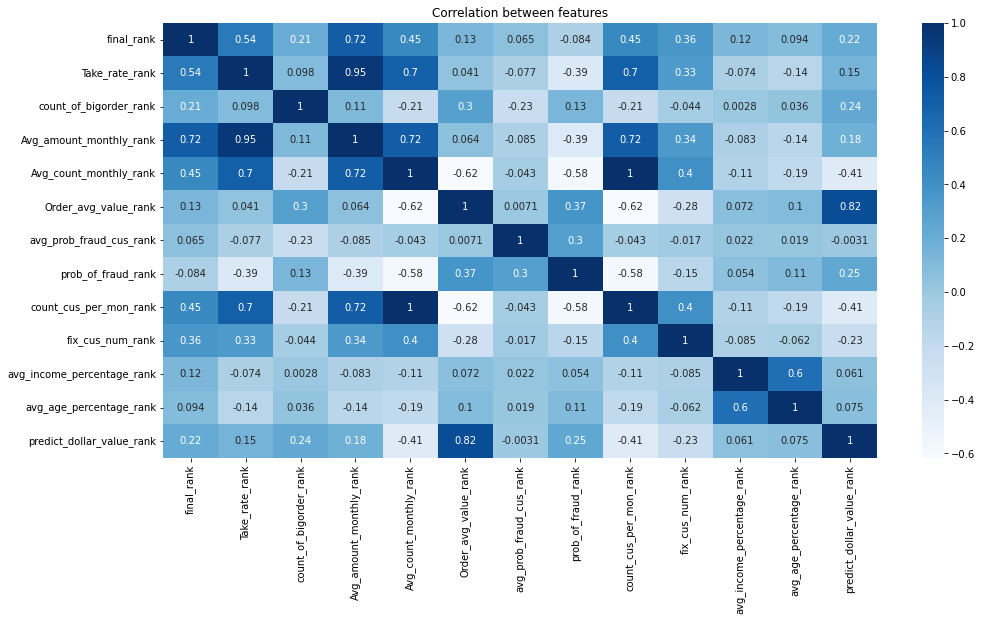

In [45]:
# Plot the heatmap to find the correlation
plt.figure(figsize=(16,8))
cor = compare_feature_rank_pic.corr()
heatmap = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
heatmap.set_title('Correlation between features')
#plt.show()
plt.savefig('../plots/heatmap.jpg', bbox_inches='tight')

In [46]:
compare_feature_rank.to_parquet('../data/curated/compare_feature_rank.parquet')